# Day 22: Implementing Multiple Linear Regression in Python 


In [7]:
#!pip install seaborn matplotlib pandas

## Introduction

Multiple linear regression is an extension of simple linear regression that is used for predicting an outcome variable ($Y$) based on multiple predictor variables ($X_1, X_2, ... X_n$). The "multiple" aspect refers to the utilization of more than one independent variable to make predictions about a dependent variable. This approach provides a more comprehensive model of the data, allowing for the interaction and combined effects of multiple predictors to be considered.

Multiple linear regression is particularly useful over simple linear regression when dealing with complex data sets where the outcome variable is likely influenced by more than a single factor. It enables the exploration and modeling of relationships between a dependent variable and several independent variables, making it a powerful tool for predictive analytics in fields such as economics, finance, healthcare, and environmental studies.

A Machine Learning practitioner should be aware of the following key equations and concepts to utilize multiple linear regression correctly:

### The Multiple Linear Regression Equation

The equation for a multiple linear regression model is expressed as:
$ Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n + \epsilon $

where:

- $Y$ is the dependent variable (target outcome),
- $\beta_0$ is the y-intercept (constant term),
- $\beta_1, \beta_2, ..., \beta_n$ are the coefficients of the independent variables which represent the change in the dependent variable for a one unit change in the respective independent variable, holding all other variables constant,
- $X_1, X_2, ..., X_n$ are the independent variables (predictors),
- $\epsilon$ is the error term, representing the difference between the observed and predicted values.

### Key Concepts for Implementation

- **Assumptions of Multiple Linear Regression**: It's crucial to ensure that the data satisfies the assumptions of linearity, independence, homoscedasticity, equal errors on both sides of the line for the model to be valid.
- **Coefficient Interpretation**: Understanding how to interpret the regression coefficients is essential for deriving meaningful insights about the relationships between independent and dependent variables.
- **Model Evaluation Metrics**: Familiarity with metrics like R-squared, Adjusted R-squared, Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) is important for assessing model performance and ensuring the best fit to the data.
- **Multicollinearity**: Awareness of the potential for multicollinearity, which occurs when independent variables are highly correlated with each other. This can distort the model estimates and make the interpretation of coefficients challenging. Techniques such as variance inflation factor (VIF) analysis can be used to detect and address multicollinearity.

Let's take a quick peek at what we're hoping to achieve with a plot of today's confabulated data. We have two X variables, `Age` and `Income`, and they both have some relationship with the Y variable, `Spending_Score`. **Can we get a more accurate answer by simultaneously doing regression on both X variables?** Hopefully you guessed "yes", as that's what today's notebook is all about.

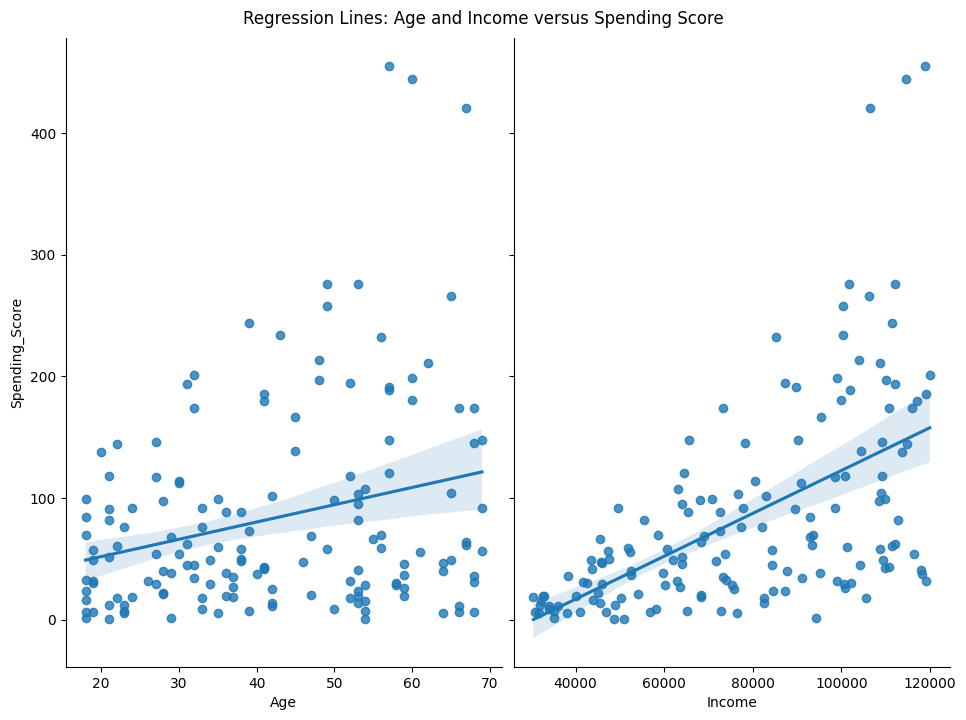

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("customer_data.csv")
g = sns.pairplot(df, x_vars=['Age','Income'], y_vars='Spending_Score', height=7, aspect=0.7, kind='reg')
g.fig.suptitle("Regression Lines: Age and Income versus Spending Score", y=1.02)
plt.show()

## On Preprocessing for Multiple Linear Regression

1. **Handling Missing Values**: Missing data can distort the analysis as it might not represent the underlying distribution of the data. It's crucial to handle them appropriately. Common strategies include filling them with the mean, median, or mode (for continuous variables), or by predicting the missing values using other data, or simply removing rows/columns with missing values.

2. **Feature Scaling**: Many machine learning algorithms, including those used in linear regression, perform better or converge faster when features are on a similar scale. Feature scaling (like standardization or normalization) is essential when the features have different scales. This is not strictly necessary for linear regression models, but it can be beneficial in models that use regularization.

3. **Encoding Categorical Variables**: If the dataset contains categorical variables, these should be converted to a numerical format. This can be done using methods like one-hot encoding or label encoding. (We will get to those eventually.) In the "customer_data.csv" example data, there are no categorical variables, so this step is not required.

Different preprocessing strategies are applied based on the nature of the data and the chosen model. For instance, tree-based models don't require feature scaling, but models like linear regression, neural networks, and support vector machines usually benefit from it. Handling missing values and encoding categorical variables are generally necessary steps regardless of the model being used.

Note that even when scaling values, we train a scaling model on separate training data, then apply it to the test data. Don't let test data leak in to **any** of your model configuration.

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('customer_data.csv')

# Check for missing values and handle them if necessary
if df.isnull().sum().any():
    df.fillna(df.mean(), inplace=True)  # Filling missing values with the mean - rarely a wise idea, but this is class.

# Assuming 'Spending_Score' is the target variable and the rest are features
X = df.drop('Spending_Score', axis=1)
Y = df['Spending_Score']

# Splitting dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Let's take a peek at the data after scaling. The histogram should look very familiar, but take note of the X axis:

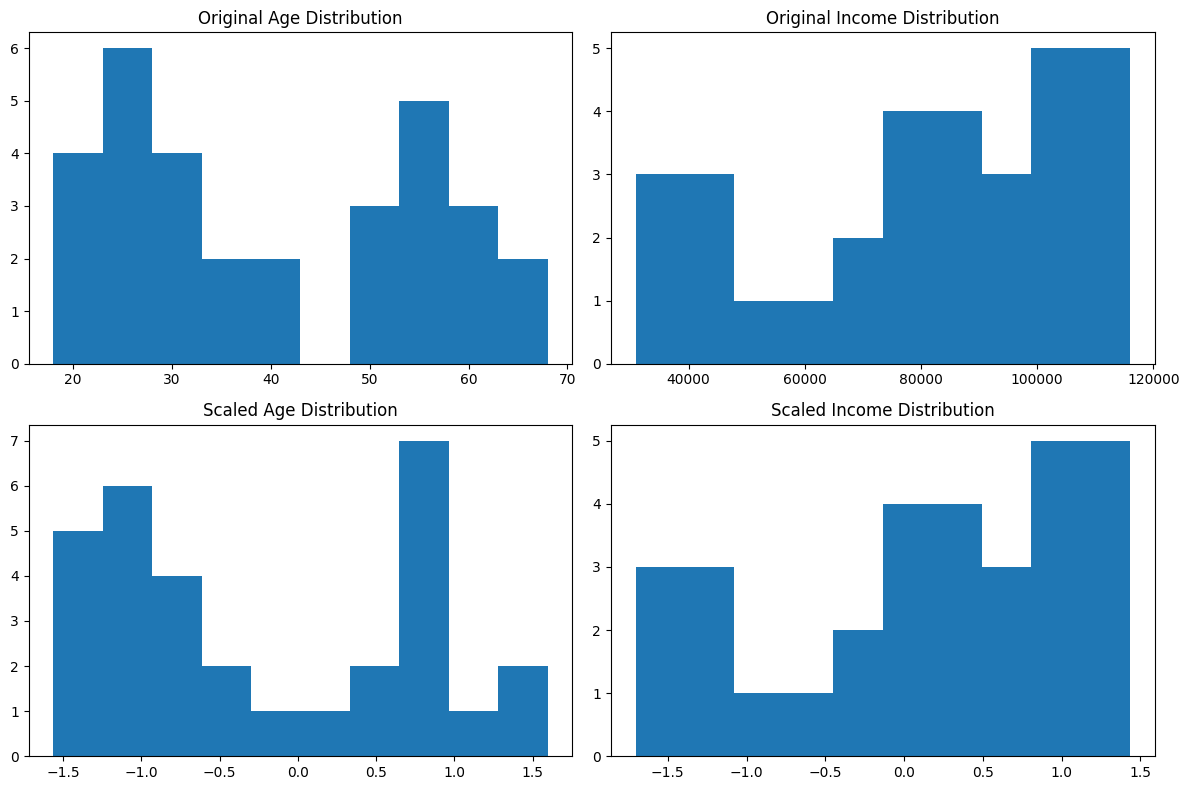

In [19]:
# Convert scaled data back to DataFrame for easier plotting
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Original Data Plots
axes[0, 0].hist(X_test['Age'])
axes[0, 0].set_title('Original Age Distribution')
axes[0, 1].hist(X_test['Income'])
axes[0, 1].set_title('Original Income Distribution')

# Scaled Data Plots
axes[1, 0].hist(X_test_scaled_df['Age'])
axes[1, 0].set_title('Scaled Age Distribution')
axes[1, 1].hist(X_test_scaled_df['Income'])
axes[1, 1].set_title('Scaled Income Distribution')

plt.tight_layout()
plt.show()

### Understanding Model Evaluation Metrics

In the context of linear regression, understanding and applying the right model evaluation metrics is crucial for assessing the model's performance and its suitability for the given data.

1. **R-squared ($R^2$)**: This metric measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It's a statistical measure between 0 and 1, where a higher value generally indicates a better fit of the model to the data. R-squared is particularly useful for comparing the explanatory power of regression models with the same dependent variable but different independent variables.

2. **MSE (Mean Squared Error)**: MSE measures the average squared difference between the observed actual outcomes and the outcomes predicted by the model. It's always non-negative, and values closer to zero are better. MSE is sensitive to outliers and can give a disproportionately high penalty to large errors, making it particularly useful when large errors are undesirable in the model.

3. **RMSE (Root Mean Squared Error)**: RMSE is the square root of MSE. It has the same units as the dependent variable, making it easier to interpret than MSE. This takes some of the benefits of MSE but makes it less punishing to a few larger errors from outliers.

In [20]:
# Model evaluation with scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Model initialization and training
model = LinearRegression()
model.fit(X_train_scaled, Y_train)

# Making predictions
predictions = model.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

print(f'MSE: {mse}')
print(f'R-squared: {r2}')


MSE: 732.3551245668029
R-squared: -0.027105564211052702


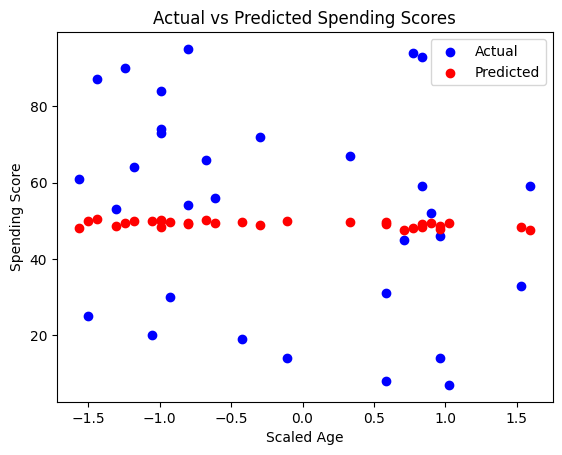

Coefficients for each independent variable: [-0.24544393  0.72516579]


In [21]:
import matplotlib.pyplot as plt

plt.scatter(X_test_scaled[:, 0], Y_test, color='blue', label='Actual')
plt.scatter(X_test_scaled[:, 0], predictions, color='red', label='Predicted')
plt.title('Actual vs Predicted Spending Scores')
plt.xlabel('Scaled Age')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

# Displaying coefficients
coefficients = model.coef_
print("Coefficients for each independent variable:", coefficients)

If you're satisfied with the results of the model, you can put the model into inference, and predict new Y values from unseen X values.

In [24]:
def predict_original_scale_dataframe(model, scaler, input_df):
    input_scaled = scaler.transform(input_df)

    # Making predictions
    predictions = model.predict(input_scaled)

    # Returning predictions as a pandas Series
    return pd.Series(predictions)

# Example usage
input_df = pd.DataFrame({'Age': [25], 'Income': [50000]})  # Values to put into inference
predictions = predict_original_scale_dataframe(model, scaler, input_df)
print(predictions[0]) # there's only one prediction, but predict_original_scale_dataframe would crunch an entire df at once.

48.57488877753046


## Exercise For The Reader

Let's have a look at the **diabetes** dataset from sklearn. Read more about the columns it contains in the sklearn docs: https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset

Some stuff you should be able to do now:
- Conduct necessary data preprocessing.
- Implement a multiple linear regression model to predict the target variable.
- Evaluate the model using R-squared and MSE metrics.
- Interpret the significance of each feature's coefficient in the context of predicting the target variable.

In [42]:
import sklearn.datasets

diabetes = sklearn.datasets.load_diabetes(as_frame=True)

In [43]:
diabetes['data'].head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [44]:
diabetes['target'].head()

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64

Have fun!

# Additional Resources

-   **Resource 1:** [Multiple Linear Regression in Python](https://www.nickmccullum.com/multiple-linear-regression-python/) (Detailed guide on multiple linear regression, including data preparation and model building)
-   **Resource 2:** [Multivariate Linear Regression Tutorial with Real Python](https://realpython.com/linear-regression-in-python/#multiple-linear-regression) (Explanation of multiple linear regression with an example using Python)

https://www.statology.org/multiple-linear-regression-assumptions/